# Generating synthtic data
The main idea here is to try make synthetic data that is _somewhat_ similar to hyperspectral data and to train some version of convnet to do sematic segmentation on it. Using synthetic data has some advantages:
- It can be made in whatever shape needed
- Endless amounts can be generated
- Labels are always true (no ambiguity)

The synthetic data doesn't have to be very realistic, i.e. very similar to real hyperspectral data. This is more a "hello world" for semantic segmentation. However, the data _should_ fulfill these requirements:
- Should have at least 2 classes
- Should have at least 2 channels
- "Annotated" shapes should vary in size

In annotated data, the classes often don't overlap spatially because it's hard to draw exact boundaries (some "gray area" is left between classes). So at least in the simplified case of syntehtic data, creating overlapping classes has low priority.



In [1]:
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
from skimage.measure import label    # See https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label
import tensorflow as tf
import numpy as np

When making "synthetic" data to be used for training / validation by TensorFlow/Keras, there are two main approaches:
- Creating the data, converting it to tensors, and converting these to Datasets (tf.data.Dataset.from_tensor_slices() and tf.data.Dataset.from_tensors)
- Generating the data "on the fly" and converting it to a Dataset ( tf.data.Dataset.from_generator() )

The last method is probably the most convenient. Note however that it has certain limitations ("While this is a convenient approach it has limited portability and scalability. It must run in the same python process that created the generator, and is still subject to the Python GIL.")

Read more here: https://www.tensorflow.org/guide/data 

In [6]:
n_rows, n_cols = 500, 500
n_shapes = 2
min_size = 100
max_size = 200
intensity_range = (0,127)

image, desc = random_shapes((n_rows,n_cols),
                        max_shapes=n_shapes,
                        min_shapes=n_shapes,
                        min_size=min_size,
                        max_size=max_size,
                        shape = 'ellipse',
                        intensity_range=intensity_range,
                        channel_axis=None)

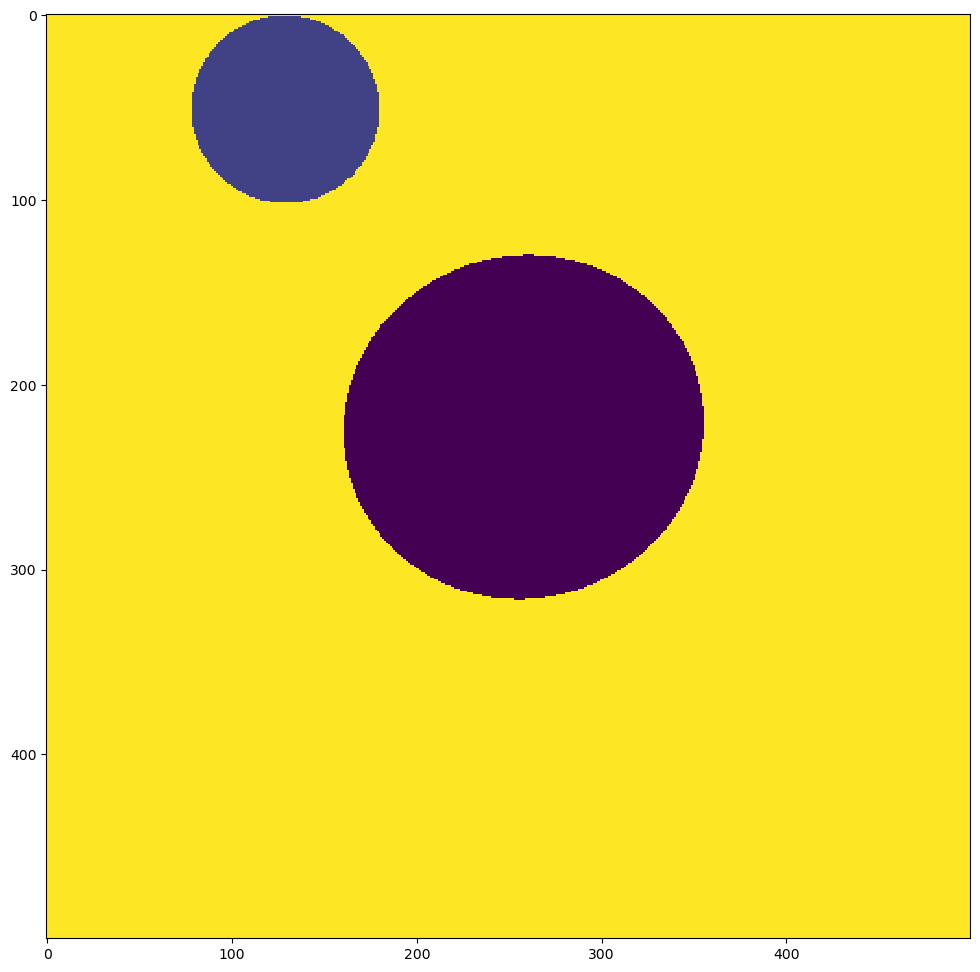

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(image,interpolation='none')
plt.show()

In [12]:
def segmentation_data_generator(n_images,
                                data_shape,
                                class_mean,
                                class_std = None,
                                min_size = 5,
                                max_size = None,
                                shape = 'ellipse'):
    """ Generate synthetic segmentation image data 
    
    # Input parameters:
    n_images:     Number of images to generate
    data_shape:   (n_rows, n_cols, n_channels)
    class_mean:   (class1_mean, class2_mean, ...)
                  Nested tuple wth mean value(s) for each class.
                  Each element contains mean values for all channels
    class_std:    (class1_mean, class2_mean, ...)
                  Nested tuple wth standard dev. value for each class.
                  Each element contains std values for all channels
                  If None, class_std is set to zero for each class
                  If non-zero, values for each class follow a Gaussian
                  distribution.
    min_size:     Minimum size (pixels) of each object
    max_size:     Maximum size of each object
    shape:        {rectangle, circle, triangle, ellipse, None} str, optional
                  Shape to generate, 'None' to pick random ones
    
    
    # Returns:
    image:        Image with dimensions (n_rows, n_cols, n_channels)
                  dtype = float64
    label         Image with dimensions (n_rows, n_cols)
                  dtype = int
                  Classes are labelled 1, 2, ... according to their
                  order in class_mean / class_std
                  Index 0 corresponds to "background" (no class)
                  
    # Notes:
    - Only generates a single object per class
    - This function relies heavily on the random_shapes function 
    from SciKit Image: https://scikit-image.org/docs/stable/api/skimage.draw.html#skimage.draw.random_shapes
    
    """
    
    n_rows, n_cols, n_channels = data_shape
    n_classes = len(class_mean)
    
    image_count = 0
    while image_count < n_images:
        # Make random shapes and label them, retrying if random_shapes() generates too few
        n_labels = None
        while n_labels != n_classes:
            # Generate random image with random intensities
            random_im, _ = random_shapes((n_rows,n_cols),
                                max_shapes=n_classes,
                                min_shapes=n_classes,
                                min_size=min_size,
                                max_size=max_size,
                                intensity_range=(0,127),
                                shape = shape,
                                num_trials=200,
                                channel_axis=None)
            # Label the random shapes (0=bacground, 1=first class, etc.)
            labels, n_labels = label(random_im,background=255,return_num=True)

        if class_std:
            noise_generator = np.random.default_rng()

        im = np.zeros(data_shape)
        for i in range(n_labels):
            class_mask = (labels==(i+1))
            im[class_mask] = class_mean[i]
            if class_std:
                noise = np.zeros(data_shape)
                for i,std in enumerate(class_std[i]):
                    noise[:,:,i] = std*noise_generator.standard_normal(size=(n_rows,n_cols))
                im[class_mask] += noise[class_mask]

        yield im, labels
        image_count += 1
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


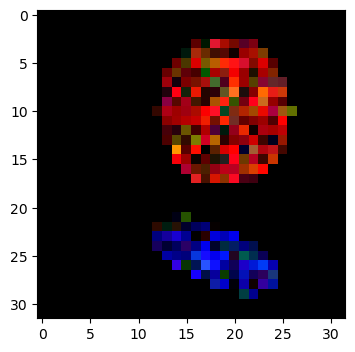

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


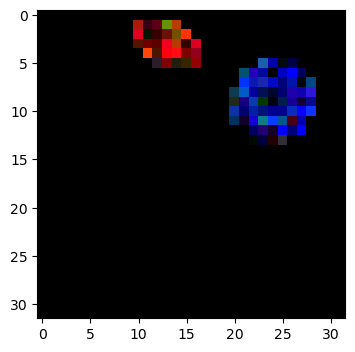

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


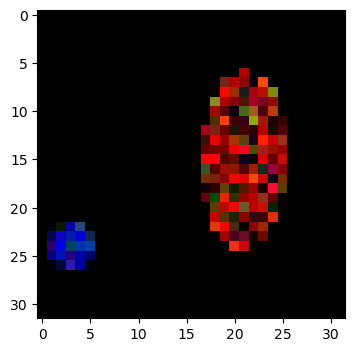

In [42]:
n_images = 3
data_shape = (32,32,3)
class_mean = ((0.5,0,0),(0,0,0.5))
class_std = ((0.3,0.2,0.1),(0.1,0.2,0.3))
#class_std = ((0,0,0),(0,0,0))

image_generator = segmentation_data_generator(n_images,data_shape,class_mean,class_std,shape='ellipse')
for image,labels in image_generator:
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.show()

In [36]:
# Stack several images on top of each other
n_images=1000
data_shape = (32,32,3)
class_mean = ((0.5,0,0),(0,0,0.5))
class_std = ((0.3,0.2,0.1),(0.1,0.2,0.3))
image_set = np.zeros((n_images,)+data_shape,dtype=np.float16)
label_set = np.zeros((n_images,)+data_shape[0:2],dtype=np.int8)
for i, data in enumerate(segmentation_data_generator(n_images,data_shape,class_mean,class_std=class_std)):
    image, labels = data
    image_set[i] = image
    label_set[i] = labels

C:\Users\mha114\Miniconda3\envs\segm\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Could not fit any shapes to image, consider reducing the minimum dimension
  return func(*args, **kwargs)


In [38]:
for i,labels in enumerate(label_set

In [37]:
image_set.size * image_set.itemsize

6144000

In [30]:
# for image, labels in zip(image_set, label_set):
#     plt.figure(figsize=(4,4))
#     plt.imshow(labels)
#     plt.show()

In [40]:
dataset = tf.data.Dataset.from_tensor_slices((image_set, label_set))
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float16, name=None), TensorSpec(shape=(32, 32), dtype=tf.int8, name=None))>

In [14]:
#ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

#arguments =  (n_images,data_shape,class_mean,class_std)
#ds_counter = tf.data.Dataset.from_generator(segmentation_data_generator, args=arguments, output_types=tf.float32, output_shapes = (), )

In [41]:
#for count_batch in ds_counter.repeat().batch(2).take(2):
#    pass
    #print(count_batch.numpy())